This experiment simulates trajectory tracking of a circular loop at increasing speeds, whilst incorporating unmodeled effects. Control is achieved by pairing a learned Koopman model of our overall system dynamics with MPC. We presume to learn lifted linear dynamics of the form $z_{k+1} = Az_k + Bu_k$ for a system with the following underlying dynamics:

$x_{k+1} = F(x_k, u_k)$

We'll extend our architecture at a later date to learn lifted bilinear dynamics of a more general form, and account for continuous spectra.

The baseline architecture implemented here is largely based off of B. Lusch et al.'s work in https://www.nature.com/articles/s41467-018-07210-0. We incorporate all loss terms from their paper, but do not account for continuous spectra. At a future date, we will enrich this loss landscape with ResDMD loss terms.

This file also implements K-fold cross validation and an automated model selection pipeline. Training data is first produced from `build_training_datasets.ipynb` and is imported here and converted to PyTorch tensors. Training data was collected by a quadrotor operating under a nominal model paired with an MPC controller, but consider ways to train your learning algorithms in the absence of a nominal model whilst also guaranteeing safety.

Notes and to-do:

- In https://www.nature.com/articles/s41467-018-07210-0, it is stated that "in practice, we enforce agreement with the trajectory data for several iterations through the dynamics, i.e. $K^m$. I tried to replicate this but did not succeed. Come back to this, or alternatively, further enrich your training set.

- Consider eliminating dependence of training on our lifting dimension, as per https://arxiv.org/pdf/1611.03537.pdf.

- I have not actually implemented a model selection pipeline yet. I think that I will first complete the full implementation (from learning our Koopman operators to pairing these operators with MPC) once, derive generalization errors, and then come back to completing model selection then. Of course, we anticipate that generalization errors will go down with a proper model selection pipeline in place.

# Part 1: Neural network training and model selection

Here, we define the neural network and perform training to learn the Koopman operator $K$ (or in the case of controlled systems, the operators $A$ and $B$). We also perform model selection via K-fold cross validation. Again, training data is produced in `build_training_datasets.ipynb` and imported.

# Define model hyperparameters

In [1]:
state_space_dim = 13 # dimension of quadrotor state vector in state-space (fixed)
control_input_dim = 4 # number of control inputs, equal to the number of quadrotor motors (fixed)
no_lifting_fcts = 10
meta_space_dim = state_space_dim * no_lifting_fcts # dimension of state-vector in lifted space

# encoder model

encoder_input_dim = state_space_dim # number of input features to encoder, equal to dimension of state-space vector
encoder_no_hidden_layers = 3 # number of hidden layers in encoder
encoder_width = 80 # width of hidden layers in encoder
encoder_output_dim = meta_space_dim # dimension of output layer, equal to dimension of state-vector in lifted space

# decoder model

decoder_input_dim = meta_space_dim # number of input features to decoder, equal to dimension of meta-space vector
decoder_no_hidden_layers = 3 # number of hidden layers in decoder
decoder_width = 80 # width of hidden layers in decoder
decoder_output_dim = state_space_dim # dimension of output layer, equal to dimension of state-space vector

# operator model ('A' matrix)

operator_A_input_dim = meta_space_dim
operator_A_output_dim = meta_space_dim

# operator model ('B' matrix)

operator_B_input_dim = control_input_dim
operator_B_output_dim = meta_space_dim

# toggle loss terms

reconstruction_loss = False # loss associated to autoencoder reconstruction ability
linear_dynamics_loss = False # loss associated to Koopman operator's ability to propagate dynamics linearly in lifted space
state_prediction_loss = True # loss associated to network's ability to perform accurate state prediction

# import settings

file_to_import = '10272023_00.pk1'

# Import training data

In [2]:
import numpy as np
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim

device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

data_dir = os.getcwd() + '/output/data/'

with open(data_dir + file_to_import, 'rb') as pickle_file:
    data = pickle.load(pickle_file)

data['X'] = data['X'].astype(np.float32)
data['Y'] = data['Y'].astype(np.float32)
data['U'] = data['U'].astype(np.float32)

# define DMD data matrices and auxiliary information

X = torch.tensor(data['X'][:,:-1], device=device).T
Y = torch.tensor(data['Y'][:,1:], device=device).T
U = torch.tensor(data['U'], device=device).T

indices = data['indices']

Using cpu device


# Define the neural network

In [3]:
from networks import Encoder, Decoder, Operator, Adder, Predictor

encoder = Encoder(encoder_input_dim, encoder_no_hidden_layers, encoder_width, encoder_output_dim)
adder = Adder(Operator(operator_A_input_dim, operator_A_output_dim), Operator(operator_B_input_dim, operator_B_output_dim))
decoder = Decoder(decoder_input_dim, decoder_no_hidden_layers, decoder_width, decoder_output_dim)
predictor = Predictor(encoder, adder, decoder, state_space_dim, state_space_dim)

# Commence training

Epoch [100/2000], Loss: 0.6358156204223633
Epoch [200/2000], Loss: 0.30307260155677795
Epoch [300/2000], Loss: 0.19677568972110748
Epoch [400/2000], Loss: 0.15633507072925568
Epoch [500/2000], Loss: 0.11000923812389374
Epoch [600/2000], Loss: 0.07608683407306671
Epoch [700/2000], Loss: 0.065012626349926
Epoch [800/2000], Loss: 0.06000615283846855
Epoch [900/2000], Loss: 0.056149572134017944
Epoch [1000/2000], Loss: 0.051987748593091965
Epoch [1100/2000], Loss: 0.046951353549957275
Epoch [1200/2000], Loss: 0.040085505694150925
Epoch [1300/2000], Loss: 0.03424379229545593
Epoch [1400/2000], Loss: 0.031202513724565506
Epoch [1500/2000], Loss: 0.029630014672875404
Epoch [1600/2000], Loss: 0.02827119082212448
Epoch [1700/2000], Loss: 0.027337180450558662
Epoch [1800/2000], Loss: 0.0264484491199255
Epoch [1900/2000], Loss: 0.02562185563147068
Epoch [2000/2000], Loss: 0.024775030091404915


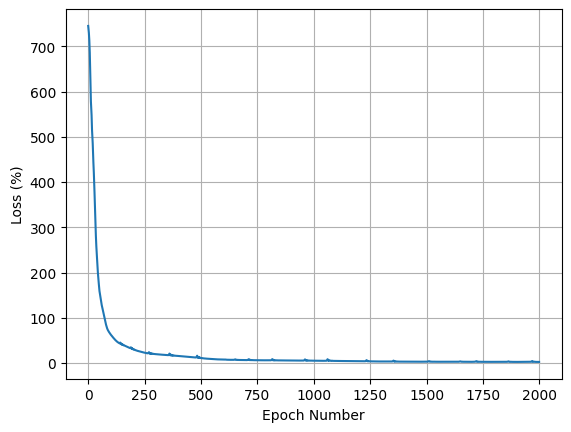

In [4]:
import matplotlib.pyplot as plt

# define loss criterion

criterion = nn.MSELoss()

# define optimizer

optimizer = optim.Adam(predictor.parameters(), lr=0.001)

# define number of epochs and perform training

num_epochs = 2000

epoch_num = []; loss_history = []

for epoch in range(num_epochs):

    target = Y
    output = predictor(X, U[:-1,:])

    # compute loss

    loss = criterion(target, output)

    # perform backpropagation

    predictor.zero_grad() # zero the gradient buffers
    loss.backward()
    optimizer.step() # perform the update

    # print the loss for tracking progress

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

    epoch_num.append(epoch)
    loss_history.append(loss.item() * 100) # express as a percentage

# print loss curve to assess convergence

plt.plot(epoch_num, loss_history)
plt.xlabel("Epoch Number")
plt.ylabel("Loss (%)")
plt.grid()
plt.show()

#################################################################################################
# WARNING: WHY IS LOSS > 100% AT THE START OF TRAINING? THIS SHOULD NOT BE POSSIBLE BY DEFINITION
#################################################################################################

# extract A and B matrices from trained predictor neural network and convert to numpy arrays

A = predictor.adder.A.operator[0].weight.data.numpy()
B = predictor.adder.B.operator[0].weight.data.numpy()

# Part 2: Trajectory tracking using Koopman-MPC

Here, we pair our learned Koopman model (captured by matrices $A$ and $B$) with MPC in order to perform quadrotor trajectory tracking. We implement here the same trajectory tracking problem that was implemented in `track_circular_nominal.ipynb`.

Notes and to-do:

- Consider ways to properly initialize and possibly vary (across our MPC time-horizon) $Q$ and $R$ weighing matrices. Some links that may be useful: https://www.researchgate.net/post/how_to_determine_the_values_of_the_control_matrices_Q_and_R_for_the_LQR_strategy_when_numerically_simulating_the_semi-active_TLCD. Where did I get the idea that $Q$ should be `np.ones()`?

# Configure simulation settings

In [ ]:
import numpy as np

# toggle simulation disturbances

simulation_disturbances = {
    "drag": True,
}
    
# define quadrotor and world properties

m = 1.0 # quadrotor mass in [kg]
J = np.array([.03, .03, .06]) # quadrotor moment of inertia vector in [kg⋅m⋅m]
l = 0.235 # length between motor and quadrotor CoG in [m]
c = 0.013 # torque generated by each motor in direction of quadrotor z-axis in [N⋅m]
T_max = 10 # max thrust generated by each motor in [N]
g = 9.81 # gravitational acceleration of world in [m/s/s]
init_pos = np.array([0.0, 1.0, 1.0]) # initial position of quadrotor

# define drag coefficients

rotor_drag = np.array([0.3, 0.3, 0.0])[:, np.newaxis] # rotor drag coefficients in [kg/m]
aero_drag = 0.08 # aerodynamic drag coefficient in [kg/m]

# define MPC and RK4 settings

t_horizon = 1.0 # prediction horizon in [s]
n_mpc_nodes = 10 # number of control nodes within horizon
Q = np.array([10, 10, 10, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]) # weighing matrix for quadratic cost function
R = np.array([0.1, 0.1, 0.1, 0.1]) # weighing matrix for quadratic cost function
simulation_dt = 5e-4 # integration step size in [s]

# define trajectory settings

traj_radius = 5 # radius of trajectory in [m]
traj_v_max = 10 # maximum speed at peak velocity in [m/s]
traj_a_lin = 1 # linear acceleration of trajectory in [m/s/s]
reference_over_sampling = 5

# toggle plotting features

animate_plots = True

# Generate reference trajectory

In [ ]:
import sys

from quad import Quad
from quad_mpc_koopman import QuadMPCKoopman
from trajectories import check_trajectory, loop_trajectory

# instantiate Quad and QuadMPC objects

quad = Quad(m=m, J=J, l=l, c=c, T_max=T_max, g=g, rotor_drag=rotor_drag, aero_drag=aero_drag, drag=simulation_disturbances["drag"])
quad_mpc = QuadMPCKoopman(quad=quad, lifted_state_dim=meta_space_dim, no_control_inputs=control_input_dim, A=A, B=B, t_horizon=t_horizon, n_nodes=n_mpc_nodes, Q=Q, R=R, encoder=predictor.encoder)

# generate reference trajectory and control policy (burrowed entirely from https://github.com/uzh-rpg/data_driven_mpc/tree/main)

control_period = t_horizon / (n_mpc_nodes * reference_over_sampling) # sampling period of trajectory

reference_traj, reference_timestamps, reference_u = loop_trajectory(
    quad=quad, discretization_dt=control_period, radius=traj_radius, 
    lin_acc=traj_a_lin, clockwise=True, yawing=False, v_max=traj_v_max, plot=True)

if not check_trajectory(reference_traj, reference_timestamps, plot=False):
    print("Reference trajectory integrity check failed!")
    sys.exit(1)

# compute reference speed

reference_speed = np.linalg.norm(reference_traj[:,7:10], axis=1)

# Perform simulation

In [ ]:
from utils.math import separate_variables
from utils.mpc import get_reference_chunk

# initialize quadrotor state

initial_state = np.split(reference_traj[0, :], [3, 7, 10])
initial_state[0] = init_pos
quad.set_state(*initial_state)

n_quad_states = len(quad.get_state())
n_control_states = len(quad.u)

# begin simulation

quad_traj = np.zeros([len(reference_timestamps), n_quad_states]) # store quadrotor trajectory
opt_u = reference_u[0, :] # optimal control action to be applied in MPC loop
opt_u_history = np.zeros([len(reference_timestamps), n_control_states]) # store optimal control action history
tracking_error = np.zeros(len(reference_timestamps)) # store tracking error

print("\nRunning MPC loop ...")

for i in range(len(reference_timestamps)):
    
    # retrieve and save quadrotor state

    quad_current_state = quad.get_state()
    quad_traj[i, :] = np.expand_dims(quad_current_state, axis=0)

    # compute tracking error

    tracking_error[i] = np.linalg.norm(reference_traj[i, :3] - quad_traj[i, :3])

    # get the chunk of trajectory required for the current optimization (burrowed entirely from https://github.com/uzh-rpg/data_driven_mpc/tree/main)

    ref_traj_chunk, ref_u_chunk = get_reference_chunk(reference_traj, reference_u, i, n_mpc_nodes, reference_over_sampling)

    # lift and set the reference for the OCP
    
    ref_traj_chunk_temp = separate_variables(ref_traj_chunk)
    lifted_ref_traj_chunk = predictor.encoder(torch.tensor(ref_traj_chunk_temp.astype(np.float32), device=device))
    
    quad_mpc.set_reference(z_ref=lifted_ref_traj_chunk, u_ref=ref_u_chunk)

    # solve OCP to retrieve optimized control and state sequences
    
    u_opt_acados, z_opt_acados = quad_mpc.optimize()

    # select first set of control actions as the control to apply to the plant

    opt_u = u_opt_acados[:4]
    opt_u_history[i, :] = np.reshape(opt_u, (1, -1)) # why is 'np.reshape' needed here?
    
    # apply control action to quadrotor and update state

    simulation_time = 0.0
    while simulation_time < control_period:
        quad.update(opt_u, simulation_dt)
        simulation_time += simulation_dt

quad_current_state = quad.get_state()
quad_traj[-1, :] = np.expand_dims(quad_current_state, axis=0)

# compute tracking RMSE

tracking_rmse = np.mean(np.sqrt(np.sum((reference_traj[:, :3] - quad_traj[:, :3]) ** 2, axis=1)))

# save trajectory data in a format tailored for EDMD algorithms

dir = '/Users/kianmolani/Dropbox/Academia/U-M/Research & Development/Project JASE/code/Python/Simulator/output/data/'

np.save(dir + "quad_traj", quad_traj)